# 2.1 Variational Autoencoders

In this tutorial we will familiarize ourselves with Variational Autoencoders (VAEs) and how they work in practice. VAEs are an extension to the common encoder-decoder architecture, where the input is projected into a lower dimensional (latent) space, which is then fully reconstructed. The latent space is learned with the aim to capture similarities between the inputs and can be used for dimensionality reduction. VAEs provide an additional flexibility, where the input is encoded into probability distributions instead of scalars. We can also sample from these distributions to generate new datapoints, which hopefully resemble the original ones!

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
from torch.distributions import Normal

from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
import os

from typing import Tuple

torch.manual_seed(0);

## Data

We will be experimenting with the popular MNIST dataset provided by `torchvision`. It contains 60 000, 28x28 grayscale images of handwritten digits. We can download it directly as follows:

In [2]:
mnist = MNIST('data', transform=ToTensor(), download=True)
dataloader = DataLoader(mnist, batch_size=100, shuffle=True)
len(mnist)

60000

Here to each sample we apply the `ToTensor()` transformation, which simply scales the input between 0 and 1 and converts the images to pytorch tensors. Since we don't have enough memory to pass the entire dataset into our model, we will use batches of size 100, utilizing the `DataLoader` from pytorch. The following shows an example image from the dataset.

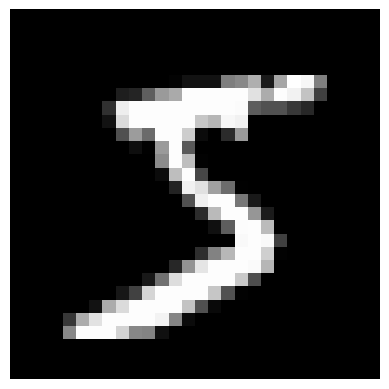

In [3]:
def show_image(idx: int) -> None:
    image = mnist[idx][0].squeeze()
    plt.imshow(image, cmap='gray')
    plt.axis('off')
    plt.show()

show_image(0)

## VAE

Now we can define our variational autoencoder. The encoder and decoder are regular feed forward neural networks. Feel free to experiment with the parameters! Our latent space will consist of $n$ independent univariate normal distributions (equivalently, an $n$-variate normal distribution with diagonal covariance), each characterized by a mean $\mu$ and a standard deviation $\sigma$. We split the network at the end of our encoder in 2: one layer for predicting the means, and one layer for predicting the standard deviations. Then, we can simply sample from the resulting distributions and reconstruct the samples using the decoder. We will be using $n=2$ in order to visualize the latent space later. Notice that this is a reduction of 99.75% (a 784-dimensional feature vector is reduced to only 2 numbers) so we cannot expect super impressive results. At the end of the tutorial, try increasing the size of the latent space and see how the reconstructions change!

Of course, there is a catch! Sampling from a distribution is a stochastic non-differentiable operation. Therefore, as soon as we sample, we lose track of the gradient and we cannot train our encoder. To circumvent this, we will be using the *reparameterization trick*, which entails generating pseudo-samples while still preserving the gradient. Given $\mathcal{N}(\mu, \sigma)$, we can generate samples $z$ as follows:

$$\epsilon\sim\mathcal{N}(0, 1)$$
$$z=\mu + \sigma\epsilon$$

Here we only scale the standard deviation and add to it the mean, which are bot differentiable operations! You can convince yourself that the operation above is exactly the same as $z\sim\mathcal{N}(\mu,\sigma)$. An intuition that might help you is that the operation above resembles the inverse of the $z$-score, where given a random variable $x$ with mean $\mu$ and standadrd deviation $\sigma$, we can set the mean to 0 and the standard deviation to 1, while preserving all other properties of data, with the following transformation:

$$z(x)=\frac{x-\mu}{\sigma}$$

Above we do the opposite, we sample from $\mathcal{N}(0,1)$, then we set the mean to $\mu$ by adding it, and set the standard deviation to $\sigma$ by scaling by it! We can also simply visualize the 2 resulting distributions to verify that they are the same:

None <AddBackward0 object at 0x785c3b0afe50>


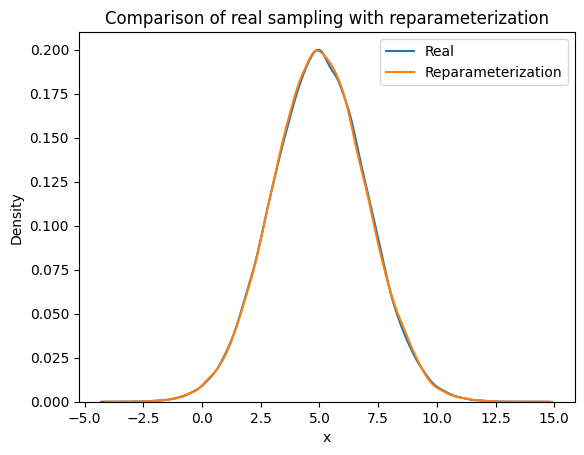

In [4]:
mu, sigma = 5., 2.
mu_tensor, sigma_tensor = torch.tensor(mu, requires_grad=True), torch.tensor(sigma, requires_grad=True)
real_dist = Normal(mu_tensor, sigma_tensor)
eps = Normal(torch.tensor(0.), torch.tensor(1.))

n_samples = 100_000
real_samples = real_dist.sample((n_samples,))
pseudo_samples = mu_tensor + sigma_tensor * eps.sample((n_samples,))

print(real_samples.grad_fn, pseudo_samples.grad_fn)

sns.kdeplot(real_samples, label='Real')
sns.kdeplot(pseudo_samples.detach(), label='Reparameterization')
plt.legend()
plt.title('Comparison of real sampling with reparameterization')
plt.xlabel('x')
plt.show()

Another catch is that the standard deviation of a distribution must always be a non-negative number. To ensure that is the case, we use $\text{softplus}$ as an activation function to the layer responsible for the standard deviations. And that's it! Now we can define our VAE simply as follows:

In [5]:
class CustomVAE(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(28*28, 400),
            nn.ReLU(),
            nn.Linear(400, 200),
            nn.ReLU()
        )
        self.mu = nn.Linear(200, 2)
        self.sigma = nn.Sequential(nn.Linear(200, 2), nn.Softplus())
        self.decoder = nn.Sequential(
            nn.Linear(2, 200),
            nn.ReLU(),
            nn.Linear(200, 400),
            nn.ReLU(),
            nn.Linear(400, 28*28),
            nn.Sigmoid()
        )
        
    def encode(self, x: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
        x = self.encoder(x)
        mean = self.mu(x)
        std = self.sigma(x)
        return mean, std

    def reparameterize(self, mean: torch.Tensor, std: torch.Tensor) -> torch.Tensor:
        eps = torch.randn_like(mean)
        pseudo_sample = mean + std * eps
        return pseudo_sample

    def decode(self, x: torch.Tensor) -> torch.Tensor:
        x = self.decoder(x)
        return x

    def forward(self, x: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
        mean, std = self.encode(x)
        sample = self.reparameterize(mean, std)
        reconstruction = self.decode(sample)
        return reconstruction, mean, std

Before we begin training, we need to define a custom loss function. As you know from the lectures, if we use only the reconstruction loss (in our case simply the binary cross entropy), the model can *cheat* by learning a very narrow distribution. However, we want diverse samples from which we can also generate new diverse datapoints. The loss function is extended using the Kullback-Leibler divergence regularization to ensure that the learned distributions are pulled to a *prior*, which we define as another normal distribution $\mathcal{N}(0,\sigma_0)$, where $\sigma_0$ is a hyperparameter, commonly set to 1.

The KL-divergence is fully differentiable and is defined as follows for normal distributions $p$ and $q$ (for derivations, see [here](https://stats.stackexchange.com/questions/7440/kl-divergence-between-two-univariate-gaussians)):

$$KL(p,q)=\log\left(\frac{\sigma_2}{\sigma_1}\right) + \frac{\sigma_1^2+(\mu_1-\mu_2)^2}{2\sigma_2^2} - \frac{1}{2}$$

The more similar $p$ and $q$ are, the smaller $KL(p,q)$ is. Therefore, we can simply add $KL(p,q)$ to the reconstruction loss as follows:

In [6]:
def DKL(mean: torch.Tensor, std: torch.Tensor, mean_prior: float = 0., std_prior: float = 1.) -> torch.Tensor:
    
    return torch.sum(
        (std_prior / std).log() + (std ** 2 + (mean - mean_prior) ** 2) / (2 * std_prior ** 2) - .5
    )

def custom_loss(
    x: torch.Tensor, 
    reconstruction: torch.Tensor, 
    mean: torch.Tensor, 
    std: torch.Tensor, 
    mean_prior: float = 0.,
    std_prior: float = 1.
) -> torch.Tensor:
    
    bce = F.binary_cross_entropy(reconstruction, x, reduction='sum')
    dkl = DKL(mean, std, mean_prior, std_prior)
    return bce + dkl

## Training

Now we can get to training our model! Since we are using a big dataset, the training may take a while. Feel free to reduce the number of epochs or the size of the model. The process is the same as usual. Also, after training, the model weights will be saved at `custom_vae.pt` (~ 3MB) to make sure that you do not need to retrain the model every time you restart the notebook.

In [7]:
vae = CustomVAE()
optimizer = torch.optim.Adam(params=vae.parameters())

In [8]:
model_path = 'custom_vae.pt'
if os.path.exists(model_path):
    vae.load_state_dict(torch.load(model_path, weights_only=True))
else:
    epochs = 15
    for epoch in range(epochs):
        vae.train()
        train_loss = 0
        for batch_idx, (x, _) in tqdm(enumerate(dataloader)):
            x = x.flatten(1) # transform (batch_size, 1, 28, 28) to (batch_size, 784)
            optimizer.zero_grad()
            reconstruction, mean, std = vae(x)
            loss = custom_loss(x, reconstruction, mean, std)
            loss.backward()
            train_loss += loss.item()
            optimizer.step()
        print(f"Epoch {epoch+1}, Loss: {train_loss / len(dataloader.dataset):.4f}")
    torch.save(vae.state_dict(), model_path)

600it [00:09, 61.67it/s]


Epoch 1, Loss: 182.2724


600it [00:11, 53.45it/s]


Epoch 2, Loss: 160.7073


600it [00:15, 38.08it/s]


Epoch 3, Loss: 155.8882


600it [00:14, 40.49it/s]


Epoch 4, Loss: 152.7084


600it [00:12, 49.96it/s]


Epoch 5, Loss: 150.4926


600it [00:13, 43.12it/s]


Epoch 6, Loss: 148.2987


600it [00:14, 41.56it/s]


Epoch 7, Loss: 146.8833


600it [00:16, 36.95it/s]


Epoch 8, Loss: 145.7467


600it [00:16, 35.82it/s]


Epoch 9, Loss: 144.8932


600it [00:19, 30.78it/s]


Epoch 10, Loss: 143.9531


600it [00:16, 35.81it/s]


Epoch 11, Loss: 143.4711


600it [00:16, 36.89it/s]


Epoch 12, Loss: 143.0461


600it [00:16, 37.08it/s]


Epoch 13, Loss: 142.1929


600it [00:18, 33.21it/s]


Epoch 14, Loss: 141.9683


600it [00:17, 33.73it/s]

Epoch 15, Loss: 141.3438


## Evaluation

We can see that our model is definitely learning! Let's visualize a reconstruction of a training sample:

In [9]:
def reconstruct_image(idx: int = 0) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor, torch.Tensor]:
    image = mnist[idx][0].flatten(1)
    with torch.inference_mode():
        reconstruction, mean, std = vae(image)
    return image.squeeze().reshape(28, 28), reconstruction.squeeze().reshape(28, 28), mean.squeeze(), std.squeeze()

def show_reconstruction(original_image: torch.Tensor, reconstruction: torch.Tensor) -> None:
    fig, ax = plt.subplots(ncols=2)
    ax[0].imshow(original_image, cmap='gray')
    ax[0].axis('off')
    ax[0].set_title('Original')
    ax[1].imshow(reconstruction, cmap='gray')
    ax[1].axis('off')
    ax[1].set_title('Reconstruction')
    plt.tight_layout()
    plt.show()

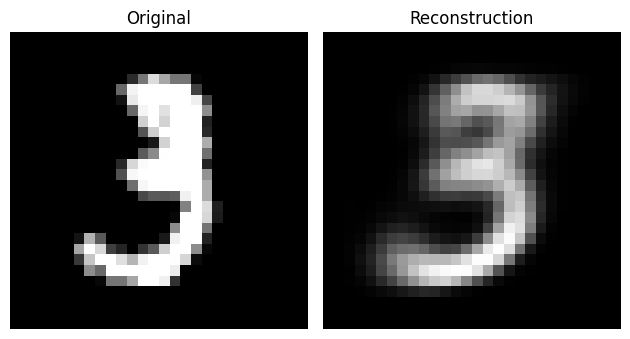

In [10]:
idx = 10
original, reconstruction, mean, std = reconstruct_image(idx)
show_reconstruction(original, reconstruction)

It seems that our model is doing quite a decent job! Let us now visualize the latent space:

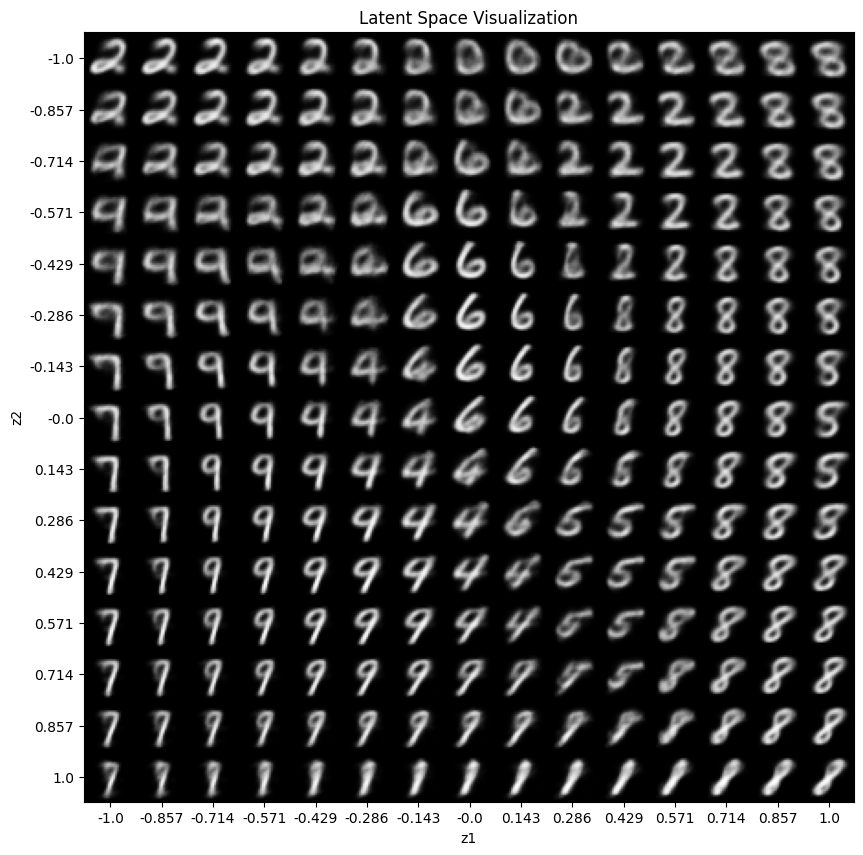

In [11]:
def visualize_latent_space():

    # How many images to show per row and column
    rows, cols = 15, 15

    # Samples of the latent space
    xs = torch.linspace(-1, 1, cols)
    ys = torch.linspace(-1, 1, rows)
    samples = torch.stack([torch.stack((x, y)) for x in xs for y in ys])
    
    # Calculate the reconstructions
    with torch.inference_mode():
        images = vae.decode(samples).reshape(rows, cols, 28, 28)

    # Concatenate all reconstructions into a grid
    grid = torch.cat([torch.cat([images[i, j] for i in range(rows)], dim=1) for j in range(cols)], dim=0)
    
    # Plot them
    fig = plt.figure(figsize=(10,10))
    xticks, yticks = range(14, (cols) * 28 + 14, 28), range(14, (rows) * 28 + 14, 28)
    xlabels, ylabels = xs.round(decimals=3).numpy(), ys.round(decimals=3).numpy()
    plt.xticks(ticks=xticks, labels=xlabels)
    plt.yticks(ticks=yticks, labels=ylabels)
    plt.xlabel('z1')
    plt.ylabel('z2')
    plt.imshow(grid,cmap='gray')
    plt.title('Latent Space Visualization')
    plt.show()

visualize_latent_space()

This looks really cool! Experiment with the parameters, i.e. the range of the samples in the latent space (e.g. not between -1 and 1 but try -5 to 5) and the resolution (not 15 by 15 but try 20 by 20)

## Your Task

For the rest of the tutorial you can implement a discrete VAE using the Gumbel-softmax trick. In our current implementation the latent space of the VAE is continuous. However, we are often interested in generating images of discrete classes (such as here, digits 0-9). Instead of encoding the input into $n$ normal distributions with means and standard deviations, we can encode it instead into $n$ categorical distributions with 10 categories. To implement this, the last layer of the encoder could be a linear layer that projects the input onto a $10n$-dimensional space. The result can be then simply reshaped reshaped into a $n\times 10$ matrix, where the $i$-th row are the logits of the $i$-th categorical distribution.

Great! Now how do we sample from a categorical distribution while preserving the gradient? The key is to use the Gumbel-softmax trick! The Gumbel distribution is defined as follows:

$$\text{Gumbel}=-\log\left(-\log\left(U\left(0,1\right)\right)\right)$$

Where $U(0,1)$ is the uniform distribution between 0 and 1. We can add Gumbel noise to each category in each distribution and "sample" using the $\text{softmax}$ with temperature $\tau$ as follows:

$$z_i=\text{softmax}\left(\frac{\log(\alpha_i) + \text{Gumbel}}{\tau}\right)$$

Here $\alpha_i$ is the 10 logits of the $i$-th categorical distribution and the $\log$ function is applied element-wise. We can then concatenate the resulting $n$ 10-dimensional vectors $z_i$ and directly pass them to the decoder. Here we are simply taking the log element-wise, adding a constant, dividing by a constant, and taking the softmax, which are all differentiable operations! Also, we are using *soft* sampling, where instead of picking a single category, we pick a probability distribution over the categories. This is important since picking a single category is non-differentiable.

In this case we want our prior to be uniform distribution. To achieve that we can replace our regularization term with the formula for the KL divergence between 2 categorical distributions $p$ and $q$, which is as follows:

$$KL(p,q)=\sum_jp_j\log\left(\frac{p_j}{q_j}\right)$$

Where $p_j$ and $q_j$ are the respective probabilities for the $j$-th category. A uniform categorical distribution with $C$ categories is defined as $p_i=\frac{1}{C}, i=1\ldots C$.

In [12]:
# Your code here